In [58]:
from backtest import ticker_stats, smooth, features, stringify, print_ticker_heading, balanced_scorecard, \
                     determine_minima_n_maxima, align_minima_n_maxima, plot_trades, split_data, \
                     get_signals, merge_buy_n_sell_signals, extract_trades, get_possible_trades
import pandas as pd
import numpy as np

from   frankie     import DayForecast, optimize, baseline, cross_val_tpr
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from datetime import date, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter, argrelmin, argrelmax

import gc; gc.enable()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
DATAPATH = '/Users/frkornet/Flatiron/Stock-Market-Final-Project/data/'
sdf = pd.read_csv(f'{DATAPATH}optimal_params.csv')

sdf = sdf.loc[sdf.up3_tpr > 0.0].reset_index()
if 'index' in sdf.columns:
    del sdf['index']
sdf.head(20)

,NAME_OF_ISSUER,CUSIP,VALUE,SHRS_OR_PRN_AMT,SOLE_VOTING_AUTH,NO_VOTING_AUTH,TICKER,up3_period,up3_lags,up3_tpr,...,up8_lags,up8_tpr,up10_period,up10_lags,up10_tpr,naive1_tpr,naive3_tpr,naive5_tpr,naive10_tpr,naive8_tpr
0,ADURO BIOTECH INC,00739L101,2902,2738200,2590838,147362,ADRO,15y,"1,3",0.9452,...,"1,3,5,10,20,30",0.9873,3y,"1,3,5",0.9595,0,0.4286,0.4091,0.4286,0.4740
1,BMC STK HLDGS INC,05591B109,34168,1305100,1175955,129145,BMCH,3y,"1,3",0.9878,...,"1,3,5",1.0000,3y,"1,3",1.0000,0,0.5519,0.5584,0.6104,0.6104
2,CVR ENERGY INC,12662P108,92673,2104769,2104769,0,CVI,8y,"1,3",0.8873,...,"1,3,5,10,20,30,45",1.0000,5y,"1,3",0.9831,0,0.4026,0.3831,0.3117,0.3636
3,GRACO INC,384109104,8329,180900,72895,108005,GGG,5y,"1,3",0.9053,...,"1,3,5,10,20",1.0000,15y,"1,3,5",0.9898,0,0.5519,0.6104,0.5649,0.5584
4,GULF RESOURCES INC,40251W309,1276,1830162,1828362,1800,GURE,5y,"1,3",0.7941,...,"1,3",0.9615,15y,"1,3",1.0000,0,0.3377,0.3182,0.2857,0.2792
5,HANCOCK WHITNEY CORPORATION,410120109,9687,252962,252962,0,HWC,5y,"1,3",0.8846,...,"1,3,5,10,20,30,45",0.9880,3y,"1,3",1.0000,0,0.4870,0.4870,0.4545,0.4740
6,MBIA INC,55262C100,2108,228374,146742,81632,MBI,8y,"1,3",0.8824,...,"1,3",1.0000,3y,"1,3",0.9865,0,0.4091,0.4286,0.3831,0.4026
7,PALO ALTO NETWORKS INC,697435105,1192028,5848150,5622490,225660,PANW,3y,"1,3,5,10",0.9495,...,"1,3",0.9908,5y,"1,3",1.0000,0,0.6234,0.6494,0.5974,0.6299
8,SI BONE INC,825704109,723,40900,40900,0,SIBN,15y,"1,3,5,10,20,30,45,60",0.8933,...,"1,3",0.9684,15y,"1,3",0.9775,0,0.4935,0.5260,0.5130,0.5519
9,SPECTRUM PHARMACEUTICALS INC,84763A108,22936,2765017,2747310,17707,SPPI,3y,"1,3,5,10",0.9125,...,"1,3,5,10",1.0000,10y,"1,3,5",0.9722,0,0.4675,0.4351,0.3831,0.3961


In [4]:
tickers = sdf.TICKER.to_list()
print(tickers)

['ADRO', 'BMCH', 'CVI', 'GGG', 'GURE', 'HWC', 'MBI', 'PANW', 'SIBN', 'SPPI']


In [5]:
min_indices, max_indices = determine_minima_n_maxima(tickers, False)

tickers= ['ADRO', 'BMCH', 'CVI', 'GGG', 'GURE', 'HWC', 'MBI', 'PANW', 'SIBN', 'SPPI']


In [6]:
min_indices, max_indices = align_minima_n_maxima(tickers, min_indices, max_indices, True)

Ticker: ADRO min_id= 23 max_id= 42
      ADRO min_id= 23 max_id= 42 
Ticker: BMCH min_id= 26 max_id= 105
      BMCH min_id= 26 max_id= 105 
Ticker: CVI min_id= 92 max_id= 21
      CVI min_id= 92 max_id= 115  (*)
Ticker: GGG min_id= 88 max_id= 50
      GGG min_id= 88 max_id= 111  (*)
Ticker: GURE min_id= 109 max_id= 24
      GURE min_id= 109 max_id= 115  (*)
Ticker: HWC min_id= 133 max_id= 29
      HWC min_id= 133 max_id= 216  (*)
Ticker: MBI min_id= 84 max_id= 48
      MBI min_id= 84 max_id= 172  (*)
Ticker: PANW min_id= 106 max_id= 36
      PANW min_id= 106 max_id= 152  (*)
Ticker: SIBN min_id= 22 max_id= 53
      SIBN min_id= 22 max_id= 53 
Ticker: SPPI min_id= 87 max_id= 7
      SPPI min_id= 87 max_id= 113  (*)


In [7]:
# suppress output of plotting all the trades as this is quite a lot...
# plot_trades(tickers, min_indices, max_indices)

In [8]:
possible_trades_df = get_possible_trades(tickers, 0.5, False)
possible_trades_df.sample(10)

tickers= ['ADRO', 'BMCH', 'CVI', 'GGG', 'GURE', 'HWC', 'MBI', 'PANW', 'SIBN', 'SPPI']


,buy_date,buy_close,sell_date,sell_close,gain_pct,trading_days,daily_return,ticker
0,2019-04-04,9.51,2019-05-06,9.97,4.84,21,0.23,MBI
0,2019-10-01,37.07,2019-10-30,39.56,6.72,21,0.31,HWC
0,2017-11-13,18.64,2017-11-21,19.82,6.33,6,1.03,SPPI
0,2019-11-18,3.15,2020-01-03,2.95,-6.35,31,-0.21,GURE
0,2017-09-05,9.84,2017-09-06,10.00,1.63,1,1.63,MBI
0,2017-03-22,9.05,2017-07-19,9.15,1.10,82,0.01,GURE
0,2018-04-26,8.79,2018-05-21,8.78,-0.11,17,-0.01,MBI
0,2018-04-16,18.75,2018-06-04,20.85,11.20,34,0.31,BMCH
0,2018-11-23,16.22,2018-12-06,16.63,2.53,8,0.31,BMCH
0,2018-11-29,4.00,2019-01-07,4.70,17.50,24,0.67,GURE


In [9]:
possible_trades_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 0
Data columns (total 8 columns):
buy_date        95 non-null datetime64[ns]
buy_close       95 non-null float64
sell_date       95 non-null datetime64[ns]
sell_close      95 non-null float64
gain_pct        95 non-null float64
trading_days    95 non-null int64
daily_return    95 non-null float64
ticker          95 non-null object
dtypes: datetime64[ns](2), float64(4), int64(1), object(1)
memory usage: 6.7+ KB


In [10]:
possible_trades_df.describe()

,buy_close,sell_close,gain_pct,trading_days,daily_return
count,95.000000,95.000000,95.000000,95.000000,95.000000
mean,28.656842,29.808000,2.329158,26.242105,0.468316
std,37.984046,40.872878,11.302668,26.827945,1.043421
min,2.880000,1.190000,-62.810000,1.000000,-0.750000
25%,8.325000,8.605000,-0.025000,6.000000,0.000000
50%,18.640000,19.030000,2.750000,19.000000,0.230000
75%,40.120000,41.655000,6.695000,38.000000,0.695000
max,214.610000,227.780000,27.520000,132.000000,8.540000


In [11]:
pd.set_option("display.max_rows", 200)
display(possible_trades_df.sort_values(by=['buy_date', 'gain_pct'], ascending=[True, False]).head())
display(possible_trades_df.sort_values(by=['buy_date', 'gain_pct'], ascending=[True, False]).tail())

,buy_date,buy_close,sell_date,sell_close,gain_pct,trading_days,daily_return,ticker
0,2017-03-15,16.60,2017-05-01,18.11,9.10,32,0.27,CVI
0,2017-03-22,9.05,2017-07-19,9.15,1.10,82,0.01,GURE
0,2017-04-04,42.47,2017-05-04,45.22,6.48,21,0.30,HWC
0,2017-04-07,8.93,2017-04-10,9.03,1.12,1,1.12,MBI
0,2017-04-19,8.70,2017-04-20,8.72,0.23,1,0.23,MBI


,buy_date,buy_close,sell_date,sell_close,gain_pct,trading_days,daily_return,ticker
0,2019-10-01,37.07,2019-10-30,39.56,6.72,21,0.31,HWC
0,2019-10-14,25.23,2019-11-07,28.00,10.98,18,0.58,BMCH
0,2019-11-04,3.65,2019-11-05,3.65,0.00,1,0.00,GURE
0,2019-11-07,3.65,2019-11-08,3.70,1.37,1,1.37,GURE
0,2019-11-18,3.15,2020-01-03,2.95,-6.35,31,-0.21,GURE


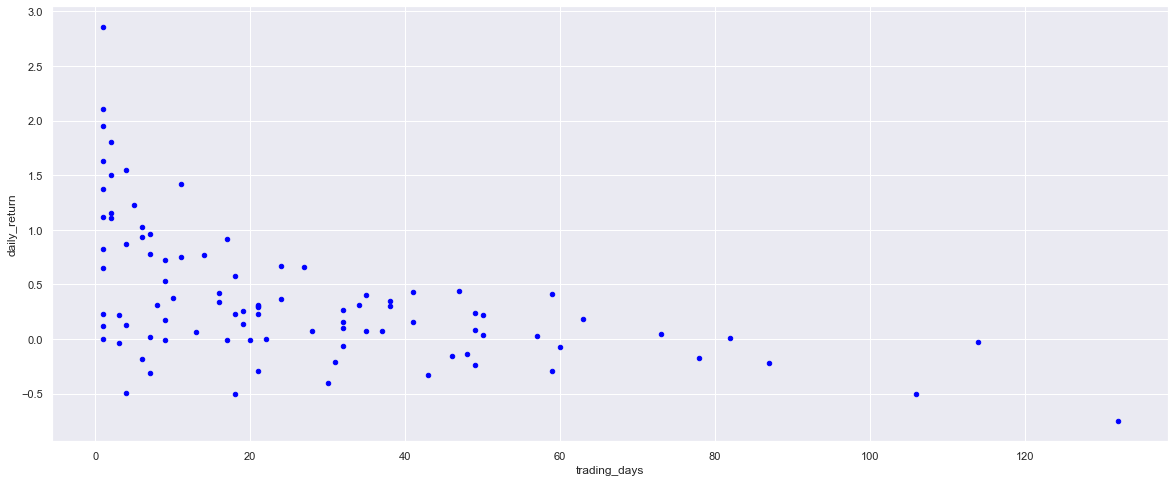

In [12]:
# ignore outlier of 8 % daily return as that distorts the plot too much
idx = (possible_trades_df.daily_return < 4)
possible_trades_df.loc[idx].plot.scatter(x='trading_days', y='daily_return', figsize=(20,8), c='Blue')

In [33]:
cols = ['ticker', 'trading_days', 'gain_pct', 'daily_return']
aggs = ['count', 'min', 'max', 'mean', 'std']
possible_trades_df[cols].groupby('ticker').agg(aggs) #.to_dict()

trading_days                                gain_pct                \
              count min  max       mean        std    count    min    max   
ticker                                                                      
ADRO              3   4  132  59.000000  65.871086        3 -62.81  19.44   
BMCH             10   4   41  17.700000  12.979043       10 -11.30  16.87   
CVI               8  14   57  34.125000  16.383245        8  -6.69  11.78   
GGG              11   1   60  16.545455  20.225546       11  -7.30   5.73   
GURE             15   1   82  23.466667  25.113646       15 -15.65  17.50   
HWC              15   2   87  24.200000  22.615418       15 -17.34  14.87   
MBI              17   1   49  15.647059  14.512672       17 -11.25  19.40   
PANW              4  38  114  71.000000  32.072834        4  -3.62  27.52   
SPPI             12   1  106  34.916667  33.794723       12 -41.47  23.04   

                             daily_return                                  
             mean        std        count   min   max      mean       std  
ticker                                                                     
ADRO   -13.283333  43.623728            3 -0.75  0.87  0.183333  0.837695  
BMCH     4.181000   8.296255           10 -0.49  0.92  0.185000  0.485049  
CVI      5.195000   6.082027            8 -0.14  0.77  0.231250  0.270314  
GGG      0.716364   3.985371           11 -0.16  0.93  0.255455  0.362970  
GURE    -0.390000   8.479639           15 -0.50  8.54  0.984000  2.290604  
HWC      2.358667   6.723733           15 -0.22  1.50  0.360667  0.522022  
MBI      4.164118   7.098759           17 -0.24  2.11  0.605294  0.677321  
PANW    10.452500  13.562402            4 -0.03  0.41  0.195000  0.217486  
SPPI     2.311667  16.168425           12 -0.50  1.95  0.515833  0.702922

In [38]:
mean_dict = possible_trades_df[cols].groupby('ticker').agg(['mean']).to_dict()
mean_dict[('gain_pct', 'mean')]['ADRO']

-13.283333333333333

In [78]:
max(possible_trades_df.buy_date)

Timestamp('2019-11-18 00:00:00')

In [59]:
start_date, end_date = min(possible_trades_df.buy_date), max(possible_trades_df.sell_date)
start_date, end_date

(Timestamp('2017-03-15 00:00:00'), Timestamp('2020-01-03 00:00:00'))

In [62]:
start_date = start_date - timedelta(5)
end_date = end_date + timedelta(5)

In [65]:
asset = yf.Ticker('MSFT')
hist  = asset.history(period="max")
idx = (hist.index >= start_date) & (hist.index <= end_date)
backtest_trading_dates = hist.loc[idx].index.to_list()
print(backtest_trading_dates[0], backtest_trading_dates[-1])

2017-03-10 00:00:00 2020-01-08 00:00:00


In [88]:
capital           = 10000
free              = 10000
in_use            = 0
i_possible_trades = 0
possible_trades   = possible_trades_df.sort_values(by=['buy_date', 'gain_pct'], ascending=[True, False])
possible_trades   = possible_trades.reset_index()

print(len(possible_trades))

for trading_day, trading_date in enumerate(backtest_trading_dates):
    
    if i_possible_trades < len(possible_trades):
        buy_date = possible_trades.buy_date.iloc[i_possible_trades]
        
        while trading_date == buy_date:
            #
            # Determine what to do with the possible trade
            #
            
            print(trading_date, buy_date, trading_date == buy_date, "dates are equal")
            i_possible_trades = i_possible_trades + 1
            if i_possible_trades >= len(possible_trades):
                break
            buy_date = possible_trades.buy_date.iloc[i_possible_trades]
    
    #
    # Post closing of the day
    # 
    
print(i_possible_trades)


95
2017-03-15 00:00:00 2017-03-15 00:00:00 True dates are equal
2017-03-22 00:00:00 2017-03-22 00:00:00 True dates are equal
2017-04-04 00:00:00 2017-04-04 00:00:00 True dates are equal
2017-04-07 00:00:00 2017-04-07 00:00:00 True dates are equal
2017-04-19 00:00:00 2017-04-19 00:00:00 True dates are equal
2017-04-21 00:00:00 2017-04-21 00:00:00 True dates are equal
2017-04-28 00:00:00 2017-04-28 00:00:00 True dates are equal
2017-05-08 00:00:00 2017-05-08 00:00:00 True dates are equal
2017-05-19 00:00:00 2017-05-19 00:00:00 True dates are equal
2017-06-05 00:00:00 2017-06-05 00:00:00 True dates are equal
2017-06-28 00:00:00 2017-06-28 00:00:00 True dates are equal
2017-06-30 00:00:00 2017-06-30 00:00:00 True dates are equal
2017-07-17 00:00:00 2017-07-17 00:00:00 True dates are equal
2017-07-18 00:00:00 2017-07-18 00:00:00 True dates are equal
2017-07-24 00:00:00 2017-07-24 00:00:00 True dates are equal
2017-07-27 00:00:00 2017-07-27 00:00:00 True dates are equal
2017-08-02 00:00:00 2